In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

# Search target's data
target_name = 'WASP-17b'
search_result = lk.search_lightcurve(target_name,author='SPOC',exptime=120)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 12,2019,SPOC,120,66818296,0.0
1,TESS Sector 38,2021,SPOC,120,66818296,0.0


In [2]:
# Download the first set of data to get the earilest time of observation
lc = search_result[0].download()
t_ini = lc.time.value[0]

# Create a LightCuvre object with 1 row, because subsequent steps cannot append data to an empty LightCurve.
lc_appended = lk.LightCurve(time=[t_ini+2457000], flux=[1], flux_err=[0.001])

# Download and combine all the SPOC data with 120s exptime
for i in range(0,len(search_result)):
    lc = search_result[i].download()
    
    # Unmask the data and exlude the unit to make it analyzable for the following steps
    lc_unmasked_unitless = lk.LightCurve(time=lc.time, flux=lc.flux.unmasked.value, flux_err=lc.flux_err.unmasked.value)
    
    # Using Box Least Squares method to plot the power spectrum of the period
    bls = lc_unmasked_unitless.to_periodogram(method='bls',
                                              minimum_period=0.5,
                                              maximum_period=10.0,
                                              duration=np.linspace(0.01,0.33,11))
    period = bls.period_at_max_power.value
    t_conj = bls.transit_time_at_max_power.value
    duration = bls.duration_at_max_power.value

    # Create a transit mask
    transit_mask = lc.create_transit_mask(period=float(f'{period:.3f}'),
                                          transit_time=float(f'{t_conj:.2f}'),
                                          duration=float(f'{duration:.3f}'))

    # Normalized, flatten and remove the outliers of the light curve
    # Set the threshold defining outliers to 6 (below the median flux) and 4 (above the median flux) standard deviation\ 
    # instead of the default value of 5 to avoid affecting the transit signals
    lc_normalized_flattened = lc_unmasked_unitless.flatten(mask=transit_mask, window_length=501).remove_outliers(sigma_upper=4, sigma_lower=6).remove_nans()
    
    # Append the light curve data
    lc_appended = lk.LightCurve.append(lc_appended, others=lc_normalized_flattened)

print(lc_appended)

       time               flux               flux_err      
                                                           
------------------ ------------------ ---------------------
2458624.9610687764                1.0                 0.001
2458628.9527366213 0.9978756686033915  0.002243841218569253
  2458628.95412551 1.0022349285585912 0.0022448175050943067
 2458628.955514399 0.9972368017147205 0.0022430009700471283
2458628.9569032877 0.9965323118030158 0.0022417718059511284
2458628.9582921765 1.0003134854169538  0.002242861463495033
2458628.9596810653 1.0019478468261254 0.0022424246076029157
 2458628.961069954 0.9975791957627241 0.0022405357844923223
 2458628.962458843 0.9995505466994907 0.0022418727224922516
2458628.9638477317 0.9969157386876534  0.002239420570477062
               ...                ...                   ...
 2459360.544124321   0.99970393807719 0.0021699590447203073
2459360.5455132113 0.9987775963850453 0.0021730161796147374
 2459360.546902101 0.9985627757247655  0

Text(0, 0.5, 'Relative flux')

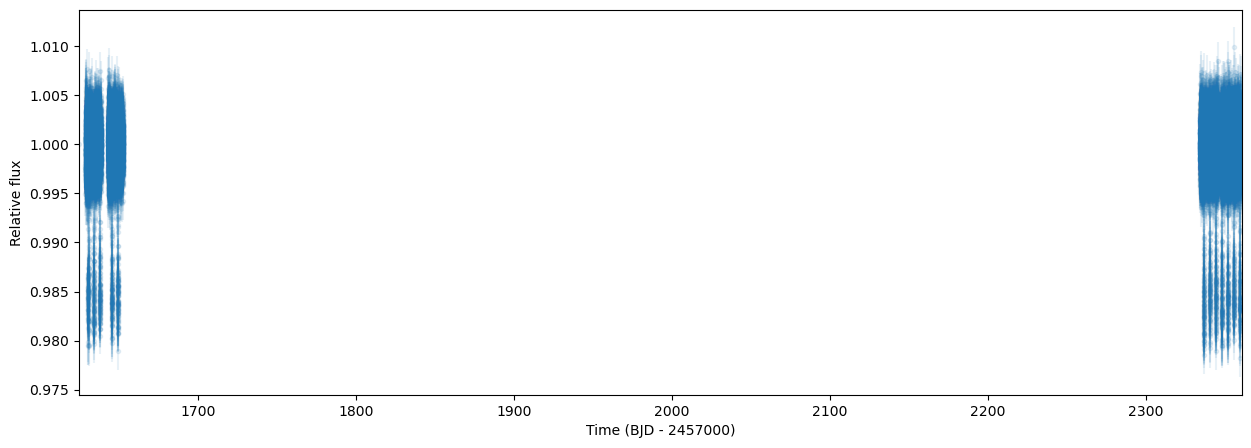

In [3]:
# Get arrays of times, preprocessed fluxes and errors
t = lc_appended.time.value-2457000
f = lc_appended.flux.value
ferr = lc_appended.flux_err.value

# Plot the preprocessed light curve
plt.figure(figsize=(15,5))
plt.errorbar(t, f, yerr=ferr, fmt='.', alpha=0.1)

plt.xlim([np.min(t),np.max(t)])
plt.xlabel('Time (BJD - 2457000)')
plt.ylabel('Relative flux')

`period` contains 122246 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


3.7354218753532913 [days]
1627.1320687765256 [BJD-2457000]
0.17 [days]


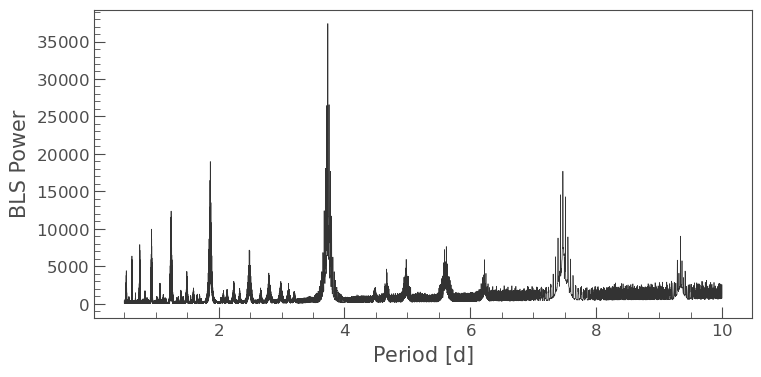

In [4]:
# Using Box Least Squares method to plot the power spectrum of the period
bls = lc_appended.to_periodogram(method='bls',
                                 minimum_period=0.5,
                                 maximum_period=10.0,
                                 duration=np.linspace(0.01,0.33,11),
                                 frequency_factor=round((np.max(t)-np.min(t))/25)**2)
                                    
bls.plot();

# Show the best fitted period, time-of-conjunction and duration
period = bls.period_at_max_power.value
t_conj = bls.transit_time_at_max_power.value-2457000
duration = bls.duration_at_max_power.value
print(period,'[days]')
print(t_conj,'[BJD-2457000]')
print(duration,'[days]')

In [5]:
import juliet
# Put data arrays into dictionaries so we can fit it with juliet:
times, fluxes, fluxes_error = {},{},{}

# Save data into those dictionaries:
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, f, ferr

# If you had data from other instruments you would simply do, e.g.,
# times['K2'], fluxes['K2'], fluxes_error['K2'] = t_k2, f_k2, ferr_k2

problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


In [6]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',\
              'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS']

# Distributions:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
              'loguniform', 'fixed', 'normal', 'loguniform']

# Hyperparameters
# --mean and standard-deviation for normal distributions
# --lower and upper limits for uniform and loguniform distributions
# --fixed values for fixed distributions
hyperps = [[float(f'{period:.3f}'), 0.1], [float(f'{t_conj:.2f}'), 0.1], [0., 1.], [0., 1.], [0., 1.], [0., 1.], 0.0, 90.,\
              [100., 10000.], 1.0, [0., 0.1], [0.1, 1000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [7]:
# Load and fit dataset with juliet:
dataset = juliet.load(priors=priors, t_lc=times, y_lc=fluxes, yerr_lc=fluxes_error, out_folder=target_name+' (V5)')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from WASP-17b (V5)/_dynesty_NS_posteriors.pkl


(-0.15, 0.15)

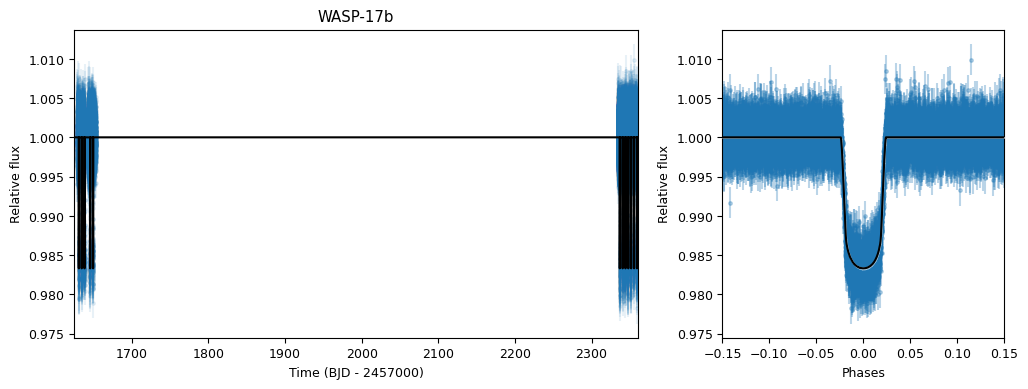

In [8]:
# Extract median model and the ones that cover the 68% credibility band around it:
transit_model, transit_up68, transit_low68  = results.lc.evaluate('TESS', return_err=True)

# To plot the phased lighcurve we need the median period and time-of-transit center:
P = np.median(results.posteriors['posterior_samples']['P_p1'])
t0 = np.median(results.posteriors['posterior_samples']['t0_p1'])

# Get phases:
phases = juliet.get_phases(dataset.times_lc['TESS'], P, t0)

import matplotlib.gridspec as gridspec

# Plot the data. First, time versus flux --- plot only the median model here:
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])

# Plot the median model:
ax1 = plt.subplot(gs[0])
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], yerr=dataset.errors_lc['TESS'], fmt='.', alpha=0.1)
ax1.plot(dataset.times_lc['TESS'], transit_model, color='black', zorder=10)

# Plot portion of the lightcurve, axes, etc.:
ax1.set_xlim([np.min(dataset.times_lc['TESS']),np.max(dataset.times_lc['TESS'])])
#ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')
ax1.set_title(target_name)

# Now plot phased model; plot the error band of the best-fit model here:
idx = np.argsort(phases)
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], yerr=dataset.errors_lc['TESS'], fmt='.', alpha=0.3)
ax2.plot(phases[idx], transit_model[idx], color='black', zorder=10)
ax2.fill_between(phases[idx], transit_up68[idx], transit_low68[idx], color='white', alpha=0.5, zorder=5)
ax2.set_ylabel('Relative flux')

# Plot portion of the lightcurve, axes, etc.:
ax2.set_xlabel('Phases')
ax2.set_xlim([-0.15,0.15])
#ax2.set_ylim([0.98,1.02])

23287
23287
23287
23287


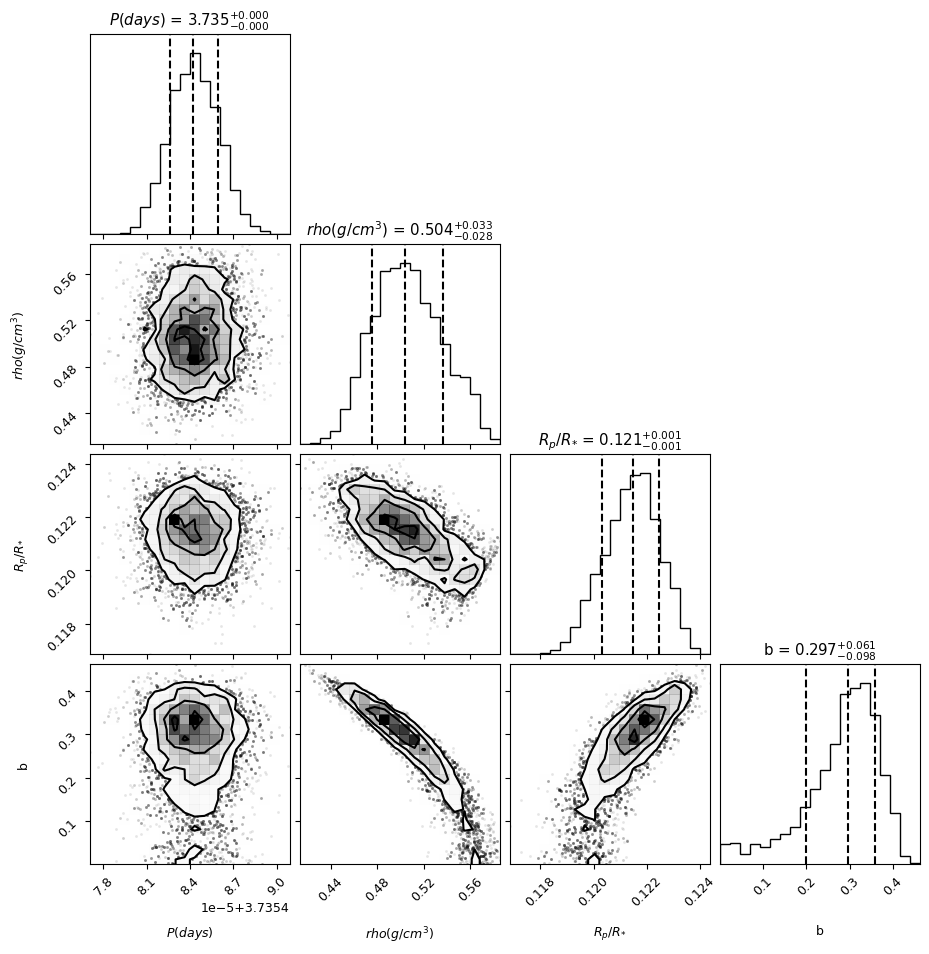

In [9]:
import corner
# Transform (r1,r2) back to (b,p)
r1, r2 = results.posteriors['posterior_samples']['r1_p1'],\
         results.posteriors['posterior_samples']['r2_p1']

b,p = juliet.utils.reverse_bp(r1, r2, 0., 1.)

# Number of data points
print(len(results.posteriors['posterior_samples']['P_p1']))
print(len(results.posteriors['posterior_samples']['rho']))
print(len(p))
print(len(b))

# Define the parameter to compare
data1 = results.posteriors['posterior_samples']['P_p1']
data2 = results.posteriors['posterior_samples']['rho']/10**3
data3 = p
data4 = b

# Integrate the data
data = np.vstack((data1, data2, data3,data4))
data_transpose = data.T

# Show the corner plot 
posterior_names = [r"$P (days)$", r"$rho (g/cm^3)$", r"$R_{p}/R_{*}$", 'b']
figure = corner.corner(data_transpose, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.3f', labels = posterior_names)